In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline


# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input, Concatenate, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils, to_categorical
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3999213139569706220
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9121512624655893590
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

    track_id       image_path       lp  train
0  s01_l01_1  s01_l01/1_1.png  7C24698      1
1  s01_l01_2  s01_l01/2_1.png  7C24698      1
2  s01_l01_2  s01_l01/2_2.png  7C24698      1
3  s01_l01_2  s01_l01/2_3.png  7C24698      1
4  s01_l01_2  s01_l01/2_4.png  7C24698      1
182336
1200
2400
3600
4800
6000
7200
8400
9600
10800
12000
13200
14400
15600
16800
18000
19200
20400
21600
22800
24000
25200
26400
27600
28800
30000
31200
32400
33600
34800
36000
37200
38400
39600
40800
42000
43200
44400
45600
46800
48000
49200
50400
51600
52800
54000
55200
56400
57600
58800
60000
61200
62400
63600
64800
66000
67200
68400
69600
70800
72000
73200
74400
75600
76800
78000
79200
80400
81600
82800
84000
85200
86400
87600
88800
90000
91200
92400
93600
94800
96000
97200
98400
99600
100800
102000
103200
104400
105600
106800
108000
109200
110400
111600
112800
114000
115200
116400
117600
118800
120000
121200
122400
123600
124800
126000
127200
128400
129600
130800
132000
133200
134400
135600
136800
138000
139

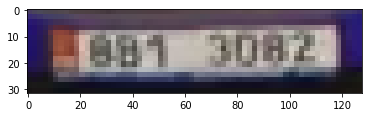

8B13082


'\nfor i in range(800):\n    #str(i).zfill(4)\n    #format(i, \'04d\')\n    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, \'04d\') + ".png")\n    print(img.shape)\n    #plt.imshow(img)\n    #plt.show()\n\nimg = cv2.imread("../../DIV2K_train_HR/0002.png")\nimg2 = img[0:1024, 0:1024,:]\nimg2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb\nplt.imshow(img2)\nplt.show()\n'

In [3]:
"""
    Reading Data from files
"""
import gc

data = pd.read_csv("../../image/trainVal.csv")
#print(data)
print(data.head())
#inputX = data[["Unnamed: 0", "w1 = 4"]].to_numpy() #需要為 np.array 的形式!

print(len(data))#182336

#train valid test
#total 105924
dataX = np.zeros((20000, 32, 128, 3), dtype=int)
dataY = []
finalTestX = np.zeros((20000, 16, 64, 3), dtype=int)
count = 0

""" 
# not load test yet, due to not enough memory
finalTestX = np.zeros((76412, 32, 128, 3), dtype=int)
finalTestY = np.zeros((76412, 32, 128, 3), dtype=int)
testCount = 0
"""

#cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) → dst
i = 0
for j in range(len(data)):
    #img = cv2.imread("../../image/s01_l01/1_1.png")
    if data["train"][i] == 0:
        img = cv2.imread("../../image/" + data["image_path"][i])
        #print(img.shape)
        img = cv2.resize(img, (128, 32))
        img = cv2.resize(img, (64, 16))
        finalTestX[count] = img
        img = cv2.resize(img, (128, 32), interpolation=cv2.INTER_NEAREST)
        dataX[count] = img
        
        dataY.append(data["lp"][i])
        
        count += 1
    i+=3 
    if i % 1200 == 0:
        print(i)
        #gc.collect()
    if count == 20000:
        break;
    
print(count)
plt.imshow(dataX[5])
plt.show()
print(dataY[5])
    
    

"""
for i in range(800):
    #str(i).zfill(4)
    #format(i, '04d')
    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, '04d') + ".png")
    print(img.shape)
    #plt.imshow(img)
    #plt.show()

img = cv2.imread("../../DIV2K_train_HR/0002.png")
img2 = img[0:1024, 0:1024,:]
img2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb
plt.imshow(img2)
plt.show()
"""


In [4]:
"""
Peak Signal-to-Noise Ratio:
     > 40dB: great
    30~40dB: good
    20~30dB: bad
     < 20dB: worse
def psnr(tf_img1, tf_img2):
    return tf.image.psnr(tf_img1, tf_img2, max_val=255)
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def printHistory(history): 
    print(history.history.keys())
    """
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    """
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [5]:

"""
# reshape the data based on what backend is in use (TensorFlow or Thean)
if keras_backend.image_data_format() == 'channels_first': #Thean
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else: # TensorFlow
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1) #(batch, height, width, channels)
"""
dataX = np.array(dataX)
dataY = np.array(dataY)
# TensorFlow
dataX = dataX.reshape(-1, 32, 128, 3)

# convert data type and normalize the values (8-bit = 256 = 0...255)
dataX = dataX.astype('float32') / 255
finalTestX = finalTestX.astype('float32') / 255
print(dataX.shape)


(20000, 32, 128, 3)


In [6]:
# convert the class labels to 7*36-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, ) 
# 車牌長度為 8 26(A~Z) + 10(0~9) + 補 null
# 8 * (37)
# ord('A')


Y_data = []

"""
for _str in y_train:
    temp_train = []
    for _char in _str:
        if ord(_char) >= 65:
            temp_train += np_utils.to_categorical(ord(_char) - ord('A'), 37).tolist()
        else:
            temp_train += np_utils.to_categorical(26 + ord(_char) - ord('0') , 37).tolist()
    for i in range(8 - len(_str)):
        temp_train += np_utils.to_categorical(36 , 37).tolist()
    Y_train.append(temp_train)
    
for _str in y_test:
    temp_test = []
    for _char in _str:
        if ord(_char) >= 65:
            temp_test += np_utils.to_categorical(ord(_char) - ord('A'), 37).tolist()
        else:
            temp_test += np_utils.to_categorical(26 + ord(_char) - ord('0') , 37).tolist()
    for i in range(8 - len(_str)):
        temp_test += np_utils.to_categorical(36 , 37).tolist()
    Y_test.append(temp_test)
"""

for _str in dataY:
    temp_train = []
    for _char in _str:
        if ord(_char) >= 65:
            temp_train.append(np_utils.to_categorical(ord(_char) - ord('A'), 37).tolist())
        else:
            temp_train.append(np_utils.to_categorical(26 + ord(_char) - ord('0') , 37).tolist())
    for i in range(8 - len(_str)):
        temp_train.append(np_utils.to_categorical(36 , 37).tolist())
    Y_data.append(temp_train)
    

In [7]:
Y_data = np.array(Y_data)

Y_data = np.transpose(Y_data ,(1, 0, 2))

print(Y_data.shape)
print(dataY[0])
for element in Y_data:
    print(element[0])
#0 1 
#2 3
#4 5
#6 7

(8, 20000, 37)
5B53929
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [10]:
# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend











In [11]:
# version4
def Inception_block(inputX, filters=64, kernel_size=(3,3), increase=False):
    a = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputX)
    a = Conv2D(96, (1, 1), activation="relu", padding="same")(a)
    
    b = Conv2D(96, (1, 1), activation="relu", padding="same")(inputX)
    
    c = Conv2D(64, (1, 1), activation="relu", padding="same")(inputX)
    c = Conv2D(96, (3, 3), activation="relu", padding="same")(c)
    
    d = Conv2D(64, (1, 1), activation="relu", padding="same")(inputX)
    d = Conv2D(96, (3, 3), activation="relu", padding="same")(d)
    d = Conv2D(96, (3, 3), activation="relu", padding="same")(d)
    
    result = concatenate([a, b, c, d], axis=3)
    
    return result

def Inception_resnet_block(inputX, filterSize):
    #google v4res 
    finalSize = filterSize
    filterSize = 64
    
    a = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    
    b = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    b = Conv2D(filterSize, (3, 3), activation="relu", padding="same")(b)
    
    c = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    c = Conv2D(filterSize*3//2, (3, 3), activation="relu", padding="same")(c)
    c = Conv2D(filterSize*3//2, (3, 3), activation="relu", padding="same")(c)

    filterSize = finalSize
    
    merge = concatenate([a, b, c], axis=3)
    merge = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(merge)
    
    #shortcut
    result = Add()([merge, inputX])
    result = Activation("relu")(result)
    
    return result

def Inception(pretrained_weights = None, input_size = (16,64,3)):
    inputs = Input(input_size)

    #upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    upConv0 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(inputs)
    
    # N*32*128*64
    conv1 = Conv2D(64, (1, 1), activation='relu', padding="same")(upConv0)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Inception_resnet_block(conv1, 64)
    #conv1 = Inception_resnet_block(conv1, 64)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (1, 1), activation='relu', padding="same")(maxPool1)
    conv2 = Inception_resnet_block(conv2, 128)
    #conv2 = Inception_resnet_block(conv2, 128)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (1, 1), activation='relu', padding="same")(maxPool2)
    conv3 = Inception_resnet_block(conv3, 256)
    #conv3 = Inception_resnet_block(conv3, 256)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (1, 1), activation='relu', padding="same")(maxPool3)
    conv4 = Inception_resnet_block(conv4, 512)
    #conv4 = Inception_resnet_block(conv4, 512)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (1, 1), activation='relu', padding="same")(maxPool4)
    conv5 = Inception_resnet_block(conv5, 1024)
    #conv5 = Inception_resnet_block(conv5, 1024)
    
    # N*4*16*512
    #upConv1 = UpSampling2D(size=(2, 2))(conv5)
    upConv1 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv5)
    conv6 = Conv2D(512, (1, 1), activation='relu', padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = Inception_resnet_block(conv6, 512)
    #conv6 = Inception_resnet_block(conv6, 512)
    
    # N*8*32*256
    #upConv2 = UpSampling2D(size=(2, 2))(conv6)
    upConv2 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv6)
    conv7 = Conv2D(256, (1, 1), activation='relu', padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = Inception_resnet_block(conv7, 256)
    #conv7 = Inception_resnet_block(conv7, 256)
    
    # N*16*64*128
    #upConv3 = UpSampling2D(size=(2, 2))(conv7)
    upConv3 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv7)
    conv8 = Conv2D(128, (1, 1), activation='relu', padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = Inception_block(conv8, 128)
    #conv8 = Inception_block(conv8, 128)

    # N*32*128*64
    #upConv4 = UpSampling2D(size=(2, 2))(conv8)
    upConv4 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv8)
    conv9 = Conv2D(64, (1, 1), activation='relu', padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = Inception_resnet_block(conv9, 64)
    #conv9 = Inception_resnet_block(conv9, 64)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 32, 128, 64)  1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 64)  4160        conv2d_transpose_1[0][0]         
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 128, 64)  4160        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

== Inception ==


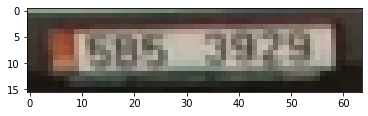

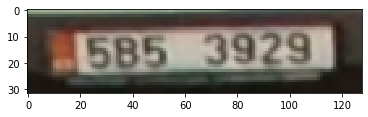

NameError: name 'finalTestY' is not defined

In [12]:
model = Inception("Inception044.h5")
print("== Inception ==")

SRresult = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = SRresult[1]
plt.imshow(img)
plt.show()


In [13]:
#input (query, documents) output 0~3
#https://blog.csdn.net/churximi/article/details/61210129

from keras.layers import Reshape
K = keras_backend
def Mix():
    inputA = Input(shape=(32, 128, 3)) # 圖片大小
    
    x = Conv2D(64, (3, 3), padding='same')(inputA) #30 126 64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x) #28 124 64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x) #14 62 64
    
    x = Conv2D(128, (3, 3), padding='same')(x) #12 60 128
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Reshape((-1, 256))(x)
    x = Dense(64, activation='relu')(x)
    
    x = LSTM(256)(x)
    x = [Dense(37, activation='softmax', name='c%d'%(i+1))(x) for i in range(8)]
    
    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=inputA, outputs=x)
    return model


model = Mix()
print(model.summary())
#https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 32, 128, 64)  1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 128, 64)  256         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 32, 128, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_75 

== Mix accuracy ==
Train loss and accuracy
[0.96415, 0.9691, 0.9556, 0.976, 0.9747, 0.9623, 0.952, 0.99785]


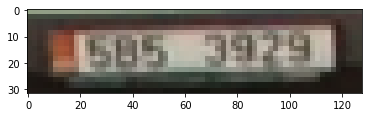

[[3.3323201e-07 9.9999046e-01 1.2941889e-07 ... 3.8328295e-11
  1.1808029e-08 6.3556421e-10]
 [3.9359941e-07 9.9998891e-01 1.6021119e-07 ... 1.0107587e-10
  8.4529965e-09 6.9788192e-10]
 [2.5720985e-07 9.9999297e-01 1.6706073e-07 ... 3.3405886e-11
  9.1385814e-09 4.0587786e-10]
 ...
 [1.3996328e-06 9.9998939e-01 2.4498043e-08 ... 2.9501254e-10
  4.0780471e-10 1.4607411e-10]
 [5.3219149e-09 9.9976450e-01 1.3383678e-07 ... 2.8123884e-07
  3.1104898e-07 5.8591082e-10]
 [7.1943087e-09 9.9997866e-01 1.6883755e-08 ... 3.4790997e-07
  1.8009356e-07 2.5604668e-10]]


In [14]:
model = Mix()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("Mix00000055.h5")
print("== Mix accuracy ==")
score = model.evaluate(dataX, [element for element in Y_data], verbose=0)
print('Train loss and accuracy')
print(score[9:])

result = model.predict(dataX)
img = dataX[1]
plt.imshow(img)
plt.show()
# show the image
print(result[1])

#printHistory(history)

== Mix accuracy ==
Train loss and accuracy
[0.9821, 0.97835, 0.9718, 0.9873, 0.9877, 0.98435, 0.97445, 0.99795]


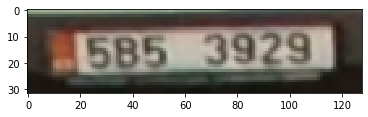

[[5.9228722e-07 9.9999368e-01 1.5902991e-07 ... 4.6882113e-11
  1.4532179e-08 8.3127322e-10]
 [2.2821077e-06 9.9998260e-01 5.2856831e-07 ... 2.1672288e-10
  2.2866084e-08 2.1243229e-09]
 [9.0405490e-07 9.9999368e-01 2.0828031e-07 ... 4.8637858e-11
  1.7541597e-08 8.4885293e-10]
 ...
 [3.6437425e-06 9.9998653e-01 6.8142981e-08 ... 4.6967363e-10
  6.8256867e-10 3.0016029e-10]
 [1.1783454e-08 9.9996507e-01 2.8734419e-08 ... 4.8679260e-07
  4.7446150e-07 4.4256165e-10]
 [2.9443960e-08 9.9994028e-01 6.0814067e-08 ... 7.2825907e-07
  5.0498551e-07 7.6316409e-10]]


In [15]:
model = Mix()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("Mix00000055.h5")
print("== Mix accuracy ==")
score = model.evaluate(SRresult, [element for element in Y_data], verbose=0)
print('Train loss and accuracy')
print(score[9:])

result = model.predict(SRresult)
img = SRresult[1]
plt.imshow(img)
plt.show()
# show the image
print(result[1])

#printHistory(history)